# 02. Baseline Reference (C3S)

## AI 기반 저탄소 시멘트 대체재 발견 파이프라인

**목적**: C3S (트리칼슘 실리케이트) 기준점 확립

---

### 왜 C3S가 Baseline인가?

| 이유 | 설명 |
|------|------|
| **산업 표준** | 포틀랜드 시멘트의 주성분 (50-70%) |
| **높은 반응성** | 빠른 수화 반응, C-S-H 젤 형성 |
| **CO₂ 주범** | 1450°C 소성 → 대량 CO₂ 발생 |
| **비교 기준** | 모든 대체재는 C3S 대비 평가 |

### 이 노트북에서 수행할 작업
1. C3S 구조 로딩 (기존 최적화 결과 활용)
2. 수화 시뮬레이션 (10 ps)
3. 기준 메트릭 정량화
4. Baseline 값 저장

## 1. 환경 설정

In [1]:
import sys
from pathlib import Path
import json
import numpy as np

# 프로젝트 루트 설정
PROJECT_ROOT = Path.cwd().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import src
from src.core import get_calculator, optimize_structure, run_md_simulation
from src.core.structure import load_structure, create_hydration_system, get_composition
from src.analysis import analyze_ca_leaching, analyze_si_coordination, analyze_csh_formation
from src.pipeline import load_config

print(f"Project Root: {PROJECT_ROOT}")
print("✓ All modules loaded")

Project Root: c:\cement_final
✓ All modules loaded


In [2]:
# 설정 로딩
sim_config = load_config("simulation")
eval_config = load_config("evaluation")

print("Simulation Config:")
print(f"  MD Duration: {sim_config['md_simulation']['screening']['duration_ps']} ps")
print(f"  Temperature: {sim_config['md_simulation']['screening']['temperature_K']} K")

Simulation Config:
  MD Duration: 10 ps
  Temperature: 300 K


## 2. C3S 구조 확인

In [3]:
# 기존 최적화된 C3S 구조 로딩
c3s_optimized_path = src.STRUCTURES_DIR / "C3S_optimized.cif"

if c3s_optimized_path.exists():
    c3s = load_structure(c3s_optimized_path)
    print("✓ Loaded existing optimized C3S structure")
else:
    # C3S 초기 구조 로딩 및 최적화
    c3s_initial_path = src.STRUCTURES_DIR / "C3S_initial.cif"
    c3s = load_structure(c3s_initial_path)
    print("Optimizing C3S structure...")
    c3s, opt_meta = optimize_structure(
        c3s,
        fmax=sim_config['optimization']['fmax'],
        max_steps=sim_config['optimization']['max_steps'],
        save_path=c3s_optimized_path
    )

# C3S 구조 정보
print("\n" + "="*50)
print("C3S Structure (Baseline)")
print("="*50)
print(f"Formula: {c3s.get_chemical_formula()}")
print(f"Atoms: {len(c3s)}")
print(f"Composition: {get_composition(c3s)}")
print(f"Cell Volume: {c3s.get_volume():.1f} Å³")

# Ca/Si 비율
comp = get_composition(c3s)
ca_si_ratio = comp.get('Ca', 0) / comp.get('Si', 1)
print(f"Ca/Si Ratio: {ca_si_ratio:.2f}")

✓ Loaded existing optimized C3S structure

C3S Structure (Baseline)
Formula: Ca9O15Si3
Atoms: 27
Composition: {'Ca': 9, 'Si': 3, 'O': 15}
Cell Volume: 374.5 Å³
Ca/Si Ratio: 3.00


## 3. 수화 시스템 생성

In [4]:
# 기존 수화 시스템 확인 또는 새로 생성
c3s_hydration_path = src.STRUCTURES_DIR / "C3S_hydration_initial.cif"

if c3s_hydration_path.exists():
    c3s_hydrated = load_structure(c3s_hydration_path)
    print("✓ Loaded existing C3S hydration system")
else:
    print("Creating C3S hydration system...")
    c3s_hydrated = create_hydration_system(
        c3s,
        n_water=sim_config['hydration']['n_water'],
        save_path=c3s_hydration_path
    )

print("\nC3S + H₂O System:")
print(f"  Formula: {c3s_hydrated.get_chemical_formula()}")
print(f"  Total Atoms: {len(c3s_hydrated)}")
print(f"  Composition: {get_composition(c3s_hydrated)}")

✓ Loaded existing C3S hydration system

C3S + H₂O System:
  Formula: H10Ca9O20Si3
  Total Atoms: 42
  Composition: {'Ca': 9, 'Si': 3, 'O': 20, 'H': 10}


## 4. MD 시뮬레이션 (Baseline)

In [5]:
# 기존 궤적 확인
c3s_traj_path = src.TRAJECTORIES_DIR / "C3S_baseline.traj"

# 기존 csh_formation 궤적 사용 가능한지 확인
existing_traj = src.TRAJECTORIES_DIR / "csh_formation_10.0ps.traj"

if existing_traj.exists():
    print(f"✓ Using existing trajectory: {existing_traj.name}")
    c3s_traj_path = existing_traj
    run_new_md = False
elif c3s_traj_path.exists():
    print(f"✓ Using existing baseline trajectory")
    run_new_md = False
else:
    run_new_md = True
    print("Will run new MD simulation for C3S baseline")

✓ Using existing trajectory: csh_formation_10.0ps.traj


In [6]:
# 새 MD 시뮬레이션 실행 (필요시)
if run_new_md:
    print("Running C3S Baseline MD Simulation...")
    print("="*50)
    
    md_config = sim_config['md_simulation']['screening']
    
    md_result = run_md_simulation(
        c3s_hydrated.copy(),
        name="C3S_baseline",
        duration_ps=md_config['duration_ps'],
        temperature=md_config['temperature_K'],
        timestep_fs=md_config['timestep_fs'],
        trajectory_dir=src.TRAJECTORIES_DIR,
        verbose=True
    )
    
    c3s_traj_path = Path(md_result['trajectory_file'])
    print(f"\n✓ MD Complete: {c3s_traj_path.name}")
else:
    print(f"Using existing trajectory: {c3s_traj_path.name}")

Using existing trajectory: csh_formation_10.0ps.traj


## 5. Baseline 분석

In [7]:
print("Analyzing C3S Baseline...")
print("="*50)

analysis_config = sim_config['analysis']

# Ca 용출 분석
print("\n[1/3] Ca Leaching Analysis...")
ca_result = analyze_ca_leaching(
    c3s_traj_path,
    distance_threshold=analysis_config['ca_leaching_threshold']
)
print(f"  Total Ca: {ca_result['n_ca']}")
print(f"  Initial Leached: {ca_result['initial_leached']}")
print(f"  Final Leached: {ca_result['final_leached']}")
print(f"  Max Leached: {ca_result['max_leached']}")
print(f"  Rate: {ca_result['rate_per_ps']:.3f} Ca/ps")

Analyzing C3S Baseline...

[1/3] Ca Leaching Analysis...
  Total Ca: 9
  Initial Leached: 0
  Final Leached: 0
  Max Leached: 0
  Rate: 0.000 Ca/ps


In [8]:
# Si 배위수 분석
print("[2/3] Si Coordination Analysis...")
si_result = analyze_si_coordination(
    c3s_traj_path,
    cutoff=analysis_config['si_coordination_cutoff']
)
print(f"  Total Si: {si_result['n_si']}")
print(f"  Initial CN: {si_result['initial_cn']:.2f}")
print(f"  Final CN: {si_result['final_cn']:.2f}")
print(f"  Mean CN: {si_result['mean_cn']:.2f}")

[2/3] Si Coordination Analysis...
  Total Si: 3
  Initial CN: 3.67
  Final CN: 3.67
  Mean CN: 3.50


In [9]:
# C-S-H 형성 분석
print("[3/3] C-S-H Formation Analysis...")
csh_result = analyze_csh_formation(
    c3s_traj_path,
    ca_si_cutoff=analysis_config['csh_pair_cutoff']
)
print(f"  Initial Pairs: {csh_result['initial_pairs']}")
print(f"  Final Pairs: {csh_result['final_pairs']}")
print(f"  Max Pairs: {csh_result['max_pairs']}")
print(f"  Min Ca-Si Distance: {csh_result['min_distance']:.2f} Å")

[3/3] C-S-H Formation Analysis...
  Initial Pairs: 11
  Final Pairs: 9
  Max Pairs: 12
  Min Ca-Si Distance: 1.78 Å


## 6. Baseline 값 정리

In [10]:
# C3S Baseline 값 정리
baseline = {
    'material': 'C3S',
    'formula': c3s.get_chemical_formula(),
    'atoms': len(c3s),
    'ca_si_ratio': float(ca_si_ratio),
    
    # 기준값 (대체재 평가에 사용)
    'reference_values': {
        'co2_reduction': 0.0,  # 기준점
        'ca_leaching_rate': float(ca_result['rate_per_ps']),
        'si_coordination': float(si_result['mean_cn']),
        'csh_pairs': int(csh_result['max_pairs'])
    },
    
    # 상세 분석 결과
    'analysis': {
        'ca_leaching': {
            'n_ca': ca_result['n_ca'],
            'initial_leached': ca_result['initial_leached'],
            'final_leached': ca_result['final_leached'],
            'max_leached': ca_result['max_leached'],
            'rate_per_ps': float(ca_result['rate_per_ps'])
        },
        'si_coordination': {
            'n_si': si_result['n_si'],
            'initial_cn': float(si_result['initial_cn']),
            'final_cn': float(si_result['final_cn']),
            'mean_cn': float(si_result['mean_cn'])
        },
        'csh_formation': {
            'initial_pairs': csh_result['initial_pairs'],
            'final_pairs': csh_result['final_pairs'],
            'max_pairs': csh_result['max_pairs'],
            'min_distance': float(csh_result['min_distance'])
        }
    },
    
    'trajectory_file': str(c3s_traj_path)
}

print("\n" + "="*60)
print("C3S BASELINE REFERENCE VALUES")
print("="*60)
print(f"\nMaterial: {baseline['material']} ({baseline['formula']})")
print(f"Ca/Si Ratio: {baseline['ca_si_ratio']:.2f}")
print("\nReference Values for Scoring:")
print("-"*40)
for key, value in baseline['reference_values'].items():
    print(f"  {key}: {value}")


C3S BASELINE REFERENCE VALUES

Material: C3S (Ca9O15Si3)
Ca/Si Ratio: 3.00

Reference Values for Scoring:
----------------------------------------
  co2_reduction: 0.0
  ca_leaching_rate: 0.0
  si_coordination: 3.501498501498501
  csh_pairs: 12


## 7. Baseline 저장

In [11]:
# Baseline 결과 저장
baseline_path = src.DATA_DIR / "results" / "c3s_baseline.json"
baseline_path.parent.mkdir(parents=True, exist_ok=True)

with open(baseline_path, 'w', encoding='utf-8') as f:
    json.dump(baseline, f, indent=2, ensure_ascii=False)

print(f"✓ Baseline saved: {baseline_path}")

✓ Baseline saved: c:\cement_final\data\results\c3s_baseline.json


In [12]:
# evaluation.yaml 업데이트 (필요시)
print("\nUpdating evaluation config with baseline values...")

eval_config['baseline'] = {
    'material': 'C3S',
    'ca_leaching_rate': baseline['reference_values']['ca_leaching_rate'],
    'si_coordination': baseline['reference_values']['si_coordination'],
    'csh_pairs': baseline['reference_values']['csh_pairs']
}

# 설정 파일 저장
import yaml
eval_config_path = src.CONFIG_DIR / "evaluation.yaml"
with open(eval_config_path, 'w', encoding='utf-8') as f:
    yaml.dump(eval_config, f, default_flow_style=False, allow_unicode=True)

print(f"✓ Updated: {eval_config_path}")


Updating evaluation config with baseline values...
✓ Updated: c:\cement_final\config\evaluation.yaml


## 8. 시각화

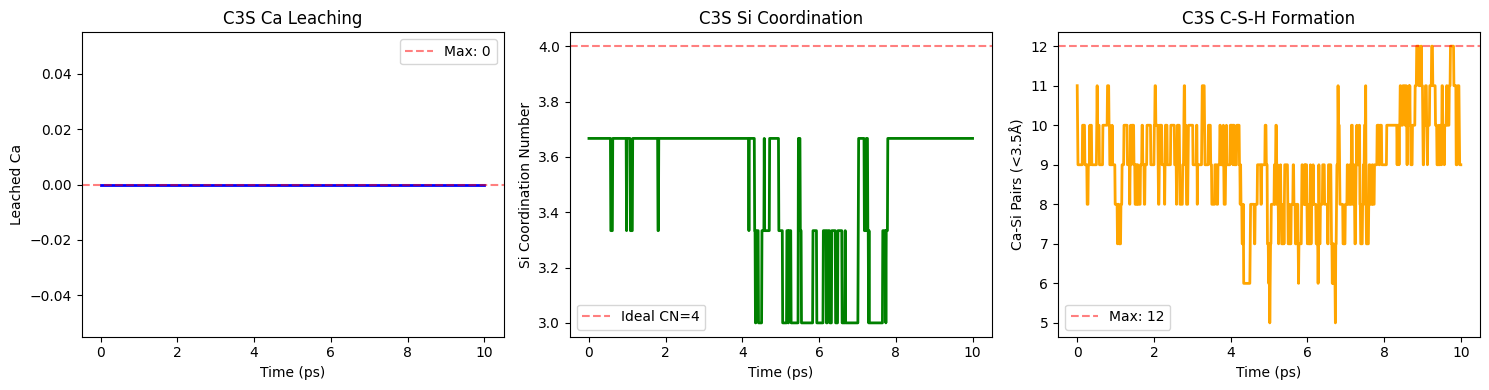


✓ Saved: c:\cement_final\figures\c3s_baseline_analysis.png


In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Ca 용출 변화
ax = axes[0]
if ca_result['leached_counts']:
    time = np.linspace(0, 10, len(ca_result['leached_counts']))
    ax.plot(time, ca_result['leached_counts'], 'b-', linewidth=2)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Leached Ca')
ax.set_title('C3S Ca Leaching')
ax.axhline(y=ca_result['max_leached'], color='r', linestyle='--', alpha=0.5, label=f"Max: {ca_result['max_leached']}")
ax.legend()

# Si CN 변화
ax = axes[1]
if si_result['cn_evolution']:
    time = np.linspace(0, 10, len(si_result['cn_evolution']))
    ax.plot(time, si_result['cn_evolution'], 'g-', linewidth=2)
ax.axhline(y=4.0, color='r', linestyle='--', alpha=0.5, label='Ideal CN=4')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Si Coordination Number')
ax.set_title('C3S Si Coordination')
ax.legend()

# C-S-H 쌍 변화
ax = axes[2]
if csh_result['pairs_evolution']:
    time = np.linspace(0, 10, len(csh_result['pairs_evolution']))
    ax.plot(time, csh_result['pairs_evolution'], 'orange', linewidth=2)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Ca-Si Pairs (<3.5Å)')
ax.set_title('C3S C-S-H Formation')
ax.axhline(y=csh_result['max_pairs'], color='r', linestyle='--', alpha=0.5, label=f"Max: {csh_result['max_pairs']}")
ax.legend()

plt.tight_layout()
plt.savefig(src.FIGURES_DIR / 'c3s_baseline_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {src.FIGURES_DIR / 'c3s_baseline_analysis.png'}")

## 9. 요약

In [14]:
print("\n" + "="*60)
print("C3S BASELINE SUMMARY")
print("="*60)

print(f"""
Material: C3S (Tricalcium Silicate)
Formula: {baseline['formula']}
Ca/Si Ratio: {baseline['ca_si_ratio']:.2f}

BASELINE REFERENCE VALUES:
─────────────────────────────────────────
  CO₂ Reduction:     {baseline['reference_values']['co2_reduction']:.0f}% (reference)
  Ca Leaching Rate:  {baseline['reference_values']['ca_leaching_rate']:.3f} Ca/ps
  Si Coordination:   {baseline['reference_values']['si_coordination']:.2f}
  C-S-H Pairs:       {baseline['reference_values']['csh_pairs']}
─────────────────────────────────────────

Files Generated:
  • {baseline_path}
  • {src.FIGURES_DIR / 'c3s_baseline_analysis.png'}

✅ Baseline established successfully!
""")

print("\n📋 Next Step: 03_Candidate_Database.ipynb")


C3S BASELINE SUMMARY

Material: C3S (Tricalcium Silicate)
Formula: Ca9O15Si3
Ca/Si Ratio: 3.00

BASELINE REFERENCE VALUES:
─────────────────────────────────────────
  CO₂ Reduction:     0% (reference)
  Ca Leaching Rate:  0.000 Ca/ps
  Si Coordination:   3.50
  C-S-H Pairs:       12
─────────────────────────────────────────

Files Generated:
  • c:\cement_final\data\results\c3s_baseline.json
  • c:\cement_final\figures\c3s_baseline_analysis.png

✅ Baseline established successfully!


📋 Next Step: 03_Candidate_Database.ipynb


---

## 완료

이 노트북에서 확립한 C3S Baseline:

| 지표 | 값 | 용도 |
|------|-----|------|
| CO₂ 저감률 | 0% | 기준점 |
| Ca 용출 속도 | X Ca/ps | 대체재 반응성 비교 |
| Si 배위수 | X.XX | 구조 안정성 비교 |
| C-S-H 쌍 | X | 결합재 형성 능력 비교 |

**다음 단계**: `03_Candidate_Database.ipynb`에서 산업 폐기물 기반 후보 데이터베이스를 구축합니다.